In [1]:
from src.neural_networks.get_data import get_tf_data, stack_1d_features, normalize_1d_features_with_mean_std, load_cv_data
from src.neural_networks.nn_forecast import NNForecast
from src.visualization.twcrpss_plot import make_twcrpss_plot_tf
from src.visualization.brier_score import make_brier_skill_plot_tf
from src.visualization.pit import make_cpit_diagram_tf, comp_multiple_pit_scores
from src.visualization.reliability_diagram import make_reliability_and_sharpness_tf
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_pdf_tf
from src.climatology.climatology import Climatology
from src.visualization.brier_score import get_brier_scores_tf
from src.models.emos import BootstrapEmos, EMOS

from scipy.stats import norm, pareto

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import optuna

2024-06-18 12:38:11.942578: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 12:38:11.945252: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 12:38:11.980581: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 12:38:17.622914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
filepath = '/net/pc200239/nobackup/users/hakvoort/hyperopt/hyperopt_emos/'

study = optuna.load_study(study_name='MOTPE_CRPS_CRPS12_long_run', storage=f'sqlite:///{filepath}/study.db')
study.set_metric_names(['CRPS', 'twCRPS12'])

/tmp/ipykernel_3761874/2379815591.py:4: ExperimentalWarning: set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.
  study.set_metric_names(['CRPS', 'twCRPS12'])


In [3]:
filepath = '/net/pc200239/nobackup/users/hakvoort/hyperopt/hyperopt_emos/'

study = optuna.load_study(study_name='MOTPE_CRPS_CRPS12_linear_constant_from_zero', storage=f'sqlite:///{filepath}/study.db')
study.set_metric_names(['CRPS', 'twCRPS12'])

/tmp/ipykernel_3761874/2842926713.py:4: ExperimentalWarning: set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.
  study.set_metric_names(['CRPS', 'twCRPS12'])


In [4]:
df = study.trials_dataframe()

new_column_names = {
    'params_chain_function_mean': 'cf_mean',
    'params_chain_function_std': 'cf_std',
    'params_chain_function_constant': 'cf_constant',
    'values_CRPS': 'CRPS',
    'values_twCRPS12': 'twCRPS12',
    'params_forecast_distribution': 'forecast_distribution',
    'params_distribution_2': 'distribution_2',
}

df.rename(columns=new_column_names, inplace=True)

In [5]:
df = df[0: 180]

In [6]:
length = 8
top_CRPS = df.sort_values('CRPS').head(length)
top_twCRPS12 = df.sort_values('twCRPS12').head(length)

In [7]:
pareto_front = study.best_trials
best_runs = [trial.number for trial in pareto_front]

pareto_trials = df['number'].isin(best_runs)

my_run = df[pareto_trials]

my_run = my_run.sort_values('CRPS')

In [8]:
all_params = ['cf_mean',
           'cf_std', 
           'cf_constant',
             'forecast_distribution', 
              'distribution_2',
                'CRPS',
             'twCRPS12',
             ]

In [4]:
features_names = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

features_names_dict = {name: 1 for name in features_names}

features_names_dict['wind_speed'] = 15

ignore = ['229', '285', '323']

In [5]:
train_data_original, test_data, data_info = load_cv_data(0, features_names_dict)

train_data = train_data_original.batch(len(train_data_original))

In [6]:
X, y = next(iter(train_data))

print(y.shape)

y = y.numpy()

(23513,)


In [7]:
def silvermans_rule(data):
    # Calculate the standard deviation of the data
    sigma = np.std(data, ddof=1)
    
    # Calculate the interquartile range (IQR) of the data
    IQR = np.percentile(data, 75) - np.percentile(data, 25)
    
    # Calculate the bandwidth using Silverman's rule
    n = len(data)
    h = 0.9 * min(sigma, IQR / 1.34) * n**(-1/5)
    
    return h

def gaussian_kernel(x):
    return norm.pdf(x)

def kde_function(data, bandwidth):
    def kde(points):
        N = len(data)
        kde_values = np.zeros(len(points))
        for i in range(len(points)):
            kde_values[i] = (1 / (N * bandwidth)) * np.sum(gaussian_kernel((points[i] - data) / bandwidth))
        return kde_values
    return kde

In [8]:
bandwith = silvermans_rule(y)

kde = kde_function(y, bandwith)

In [9]:
minimum = np.min(kde(y))
maximum = np.max(kde(y))

In [10]:
def get_weight_function(data, alpha, epsilon):
    bandwith = silvermans_rule(data)
    kde = kde_function(data, bandwith)

    max = np.max(kde(data))
    min = np.min(kde(data))

    def f_w_double_prime(points):
        p_prime = (kde(points) - min) / (max - min)

        return np.maximum(1 - alpha * p_prime, epsilon)
    
    normalization_constant = np.sum(f_w_double_prime(data)) / len(data)

    def weight_function(points):
        return f_w_double_prime(points) / normalization_constant
    
    return weight_function



In [27]:
alpha = 1.2
epsilon = 0.0001
my_weight = get_weight_function(y, alpha, epsilon)
x = np.linspace(0, 30, 20000)

In [28]:

weights = my_weight(x)

In [13]:
c = 0.05
mu = 8
sigma = 1
print(c + norm.cdf(x, loc=mu, scale=sigma))

[0.05 0.05 0.05 ... 1.05 1.05 1.05]


In [29]:
degree = 60
p = np.polynomial.Polynomial.fit(x, weights, degree)

# Generate points for plotting the fitted polynomial
x_fit = np.linspace(0, 30, 1000)
y_fit = p(x_fit)

/usr/people/hakvoort/.local/lib/python3.12/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


In [108]:
print(np.min(y_fit))

-0.02224838259585793


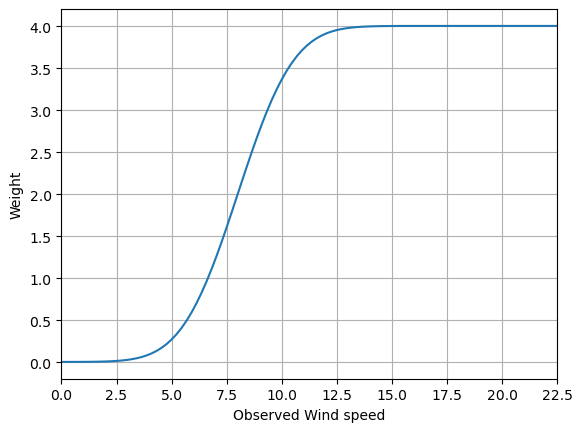

In [120]:
c = 0.001
mu = 8
std = 2
x = np.linspace(0, 22.5, 100)
y__ = c + norm.cdf(x, loc=mu, scale=std)
y__ *= 4
plt.plot(x, y__)
plt.xlabel('Observed Wind speed')
plt.ylabel('Weight')
plt.grid()
plt.xlim(x[0], x[-1])
plt.show()

In [19]:
min_y = kde(y).min()
max_y = kde(y).max()

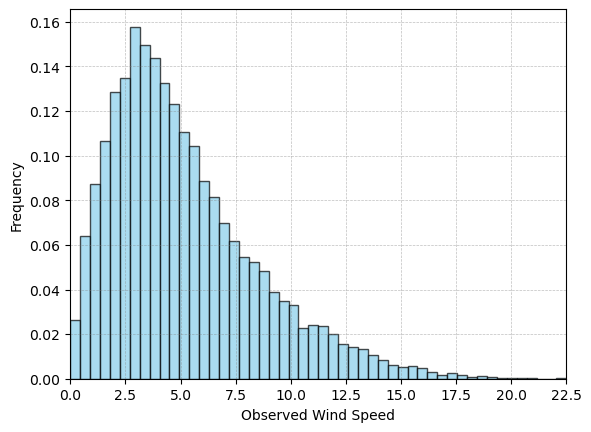

In [34]:
plt.hist(y, bins = 50, density=True, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlim(0, np.max(y))
plt.xlabel('Observed Wind Speed')
plt.ylabel('Frequency')
plt.grid(True, color='grey', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

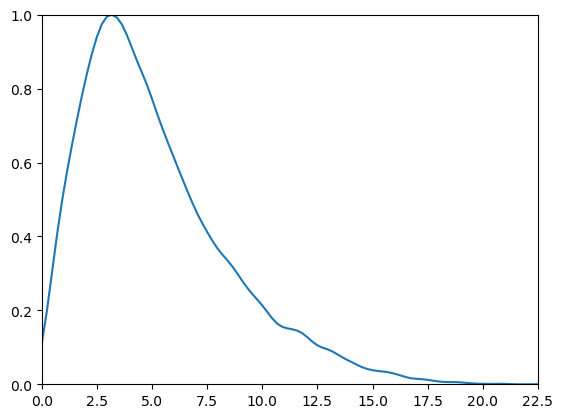

In [24]:
plt.plot(x, (kde(x) - min_y)/(max_y-min_y))
plt.ylim(0,1)
plt.xlim(x[0], x[-1])
plt.show()

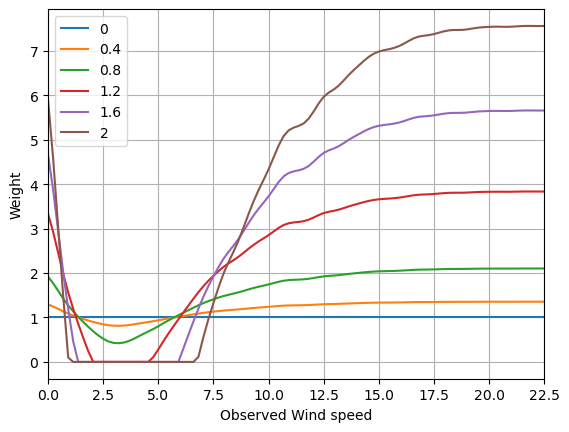

In [23]:
x = np.linspace(0, 22.5, 100)
epsilon = 0.00001
alphas = [0,0.4, 0.8, 1.2, 1.6, 2]

for alpha in alphas:
    weight_function = get_weight_function(y, alpha, epsilon)
    plt.plot(x, weight_function(x), label=alpha)

plt.xlabel('Observed Wind speed')
plt.ylabel('Weight')
plt.grid()
plt.legend()
plt.xlim(x[0], x[-1])
plt.show()

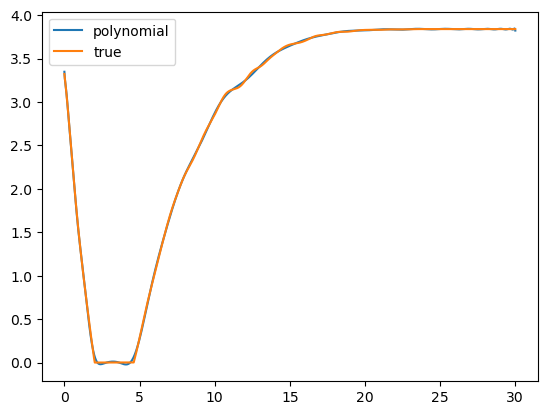

In [30]:
plt.plot(x_fit, y_fit, label='polynomial')
plt.plot(x, weights, label='true')
plt.legend()

In [129]:
np.quantile(y, 0.99)


15.426199913024902

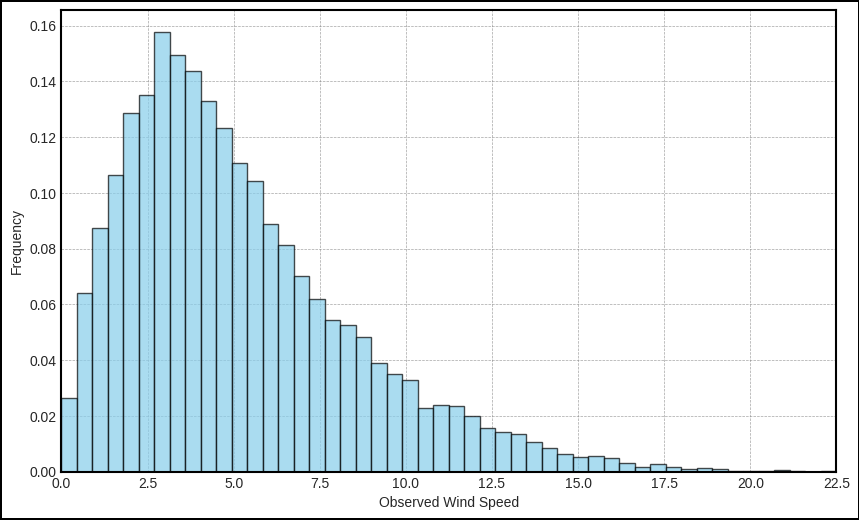

In [35]:

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axis

ax.hist(y, bins=50, density=True, color='skyblue', edgecolor='black', alpha=0.7)

ax.set_xlim(0, np.max(y))
ax.set_xlabel('Observed Wind Speed')
ax.set_ylabel('Frequency')

# Set the background of the current axes to white
ax.set_facecolor('white')

# Set the background of the figure to white
fig.patch.set_facecolor('white')

# Customize the grid
ax.grid(True, color='grey', linestyle='--', linewidth=0.5, alpha=0.7)

# Add black lines around the figure and axes
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

fig.patch.set_linewidth(1.5)
fig.patch.set_edgecolor('black')

plt.show()

In [151]:
display(top_CRPS[all_params])

,cf_mean,cf_std,cf_constant,forecast_distribution,distribution_2,CRPS,twCRPS12
24,8.014864,0.051787,0.905043,distr_mixture_linear,distr_gev,0.899754,0.059584
32,2.381427,0.000149,0.846054,distr_mixture_linear,distr_gev,0.900814,0.059747
69,7.214490,5.441655,0.245422,distr_mixture_linear,distr_gev,0.900886,0.059634
74,11.130756,9.455881,0.088957,distr_mixture_linear,distr_gev,0.900919,0.059736
45,4.450143,4.945555,0.413133,distr_mixture_linear,distr_gev,0.901207,0.059513
160,0.429430,1.295928,0.031033,distr_mixture_linear,distr_gev,0.901321,0.059876
89,7.510774,1.363924,0.396717,distr_mixture_linear,distr_gev,0.901359,0.059626
176,8.184592,0.047243,0.860618,distr_trunc_normal,NaN,0.901405,0.059753


In [152]:
display(top_twCRPS12[all_params])

,cf_mean,cf_std,cf_constant,forecast_distribution,distribution_2,CRPS,twCRPS12
51,9.649472,1.084596,0.001125,distr_mixture_linear,distr_gev,0.936089,0.059160
167,8.063486,0.427858,0.062220,distr_trunc_normal,NaN,0.910241,0.059180
66,9.860208,0.301864,0.000522,distr_log_normal,NaN,1.019796,0.059257
165,8.830960,1.068426,0.015801,distr_trunc_normal,NaN,0.921362,0.059311
30,9.571495,0.005566,0.004899,distr_mixture_linear,distr_log_normal,0.937670,0.059344
82,7.050564,2.405172,0.061703,distr_mixture_linear,distr_log_normal,0.904452,0.059380
115,9.578896,0.507889,0.026211,distr_gev,NaN,0.922650,0.059393
10,8.242517,0.047522,0.030665,distr_mixture,distr_log_normal,0.919068,0.059395


In [153]:
display(my_run[all_params])

,cf_mean,cf_std,cf_constant,forecast_distribution,distribution_2,CRPS,twCRPS12
24,8.014864,0.051787,0.905043,distr_mixture_linear,distr_gev,0.899754,0.059584
45,4.450143,4.945555,0.413133,distr_mixture_linear,distr_gev,0.901207,0.059513
162,9.614099,0.077247,0.925251,distr_mixture_linear,distr_log_normal,0.902346,0.059471
82,7.050564,2.405172,0.061703,distr_mixture_linear,distr_log_normal,0.904452,0.059380
167,8.063486,0.427858,0.062220,distr_trunc_normal,NaN,0.910241,0.059180
51,9.649472,1.084596,0.001125,distr_mixture_linear,distr_gev,0.936089,0.059160
